# Mean-shift
**segmentation / clustering algorithm**

[paper](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.76.8968&rep=rep1&type=pdf): Comaniciu, Dorin, and Peter Meer. "Mean shift: A robust approach toward feature space analysis." IEEE Transactions on pattern analysis and machine intelligence 24.5 (2002): 603-619.

In [1]:
%matplotlib inline
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import skimage.io

## Load an image

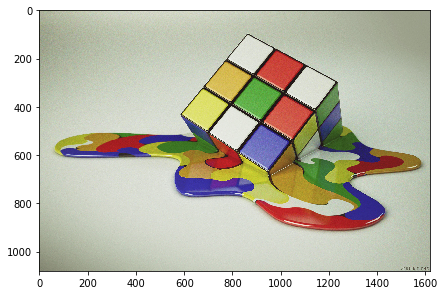

In [2]:
im = skimage.io.imread('cube1.jpg')
plt.figure(figsize=(7,7))
plt.imshow(im)

## Let's crop the image because mean-shift is known for being an expensive operation

(200, 200, 3)

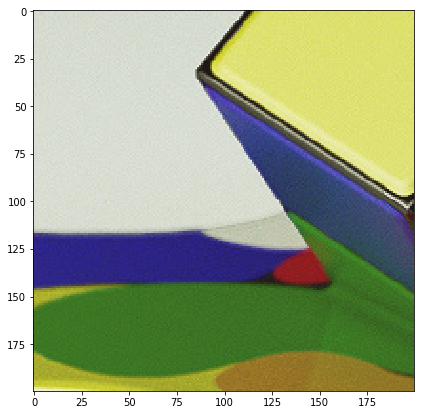

In [3]:
im = im[400:600,500:700,:]
plt.figure(figsize=(7,7))
plt.imshow(im)
im.shape

## Epanechnikov Kernel

In [4]:
def Ke(x):
    """ Epanechnikov Kernel
        x (number of points, number of feature dimensions) data points
        returns a density estimation
    """
    d = np.linalg.norm(x, axis = 1)
    m = (d <= 1)
    d[m] = 1.0 - d[m]**2
    d[np.logical_not(m)] = 0.0
    return d

In [5]:
a = np.random.rand(5,4)
print(a)
print(np.linalg.norm(a, axis = 1))
print(Ke(a))

[[ 0.28686999  0.16984595  0.23418717  0.78847571]
 [ 0.17133414  0.94331441  0.44116728  0.19373108]
 [ 0.93982641  0.84548827  0.25551754  0.49215619]
 [ 0.22991335  0.19409206  0.37652584  0.84990606]
 [ 0.14356211  0.69529701  0.89251535  0.59118858]]
[ 0.88751317  1.0730134   1.38044595  0.9770588   1.28457604]
[ 0.21232038  0.          0.          0.04535611  0.        ]


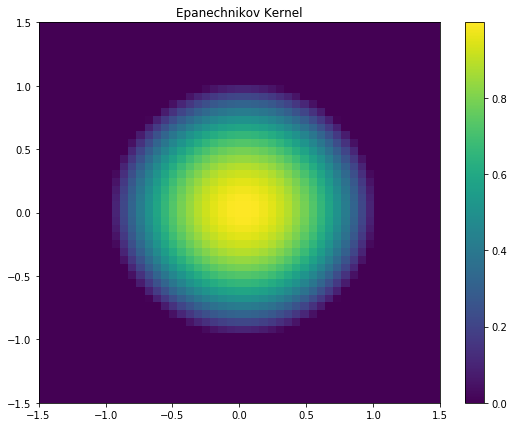

In [6]:
X, Y = np.meshgrid(np.linspace(-1.5, 1.5, 50), np.linspace(-1.5, 1.5, 50)) 
Z = Ke(np.array([X,Y]).transpose(1,2,0).reshape((-1,2)))
Z = Z.reshape((50,50))
plt.figure(figsize=(9,7))
plt.title('Epanechnikov Kernel')
plt.pcolormesh(X, Y, Z)
plt.colorbar()

## Find neighbors in feature space

In [7]:
def mean_shift_neighbors(d, x, r):
    """ Find neighbors in feature space
        d (number of points, number of feature dimensions) data points
        x (number of feature dimensions,) center point
        r kernel radius
        returns binary mask of neighbor points
    """
    return np.linalg.norm(d-x[np.newaxis,...], axis = 1)<=r

In [8]:
print(mean_shift_neighbors(a,np.zeros(4),1))

[ True False False  True False]


## Calculate mean using the density kernel as weight

In [9]:
def mean_shift_mean(neighbors, x, r):
    """ Calculate mean
        neighbors (number of points, number of feature dimensions) neighbor points
        x (number of feature dimensions,) center point
        r kernel radius
    """
    distances = np.linalg.norm(neighbors-x[np.newaxis,...], axis = 1)
    weights = Ke((neighbors-x[np.newaxis,...]) / r)
    return np.sum(neighbors*weights[...,np.newaxis], axis=0) / np.sum(weights)

## Try one iteration of mean-shift

In [10]:
def test_mean_shift():
    D = 3
    points = np.random.rand(5,D)-0.6
    print('Feature sample', points)
    r = 1
    m_neighbors = mean_shift_neighbors(points, np.zeros(D), r)
    print('Neighbor mask',m_neighbors)
    mean = mean_shift_mean(points[m_neighbors], np.zeros(D), r)
    print('Mean(Epanechnikov)',mean)
    print('Mean(flat kernel)',np.mean(points, axis=0))

test_mean_shift()

Feature sample [[-0.38332831  0.1119633  -0.37095399]
 [-0.27760202  0.39786061 -0.32341346]
 [ 0.18818759 -0.23388228 -0.38594572]
 [-0.53325025  0.29625007 -0.20891215]
 [-0.43180482  0.09547333 -0.28919638]]
Neighbor mask [ True  True  True  True  True]
Mean(Epanechnikov) [-0.27188324  0.11818172 -0.32033392]
Mean(flat kernel) [-0.28755956  0.13353301 -0.31568434]


## Mean-shift algorithm
DISCLAIMER: Demonstration only.. This implementation is going to be super slow!

In [11]:
def mean_shift(d, r, seeds, max_iterations=300):
    for p in seeds:
        origin = p.copy(); ct = 0
        while 1:
            neighbors = d[mean_shift_neighbors(d, p, r)]
            pre = p
            p = mean_shift_mean(neighbors, pre, r)
            if np.linalg.norm(p - pre) < 0.01 or ct >= max_iterations:
                print(origin, '->', p)
                break
            ct += 1

seeds = im[10:50:10,10:50:10,:].reshape(-1, 3)
print(seeds.shape)
output = mean_shift(im.reshape((-1, 3)), 5, seeds)

(16, 3)
[211 217 205] -> [ 215.72174108  220.16734603  209.12959577]
[216 223 207] -> [ 215.76434484  220.20776276  209.23182737]
[215 220 214] -> [ 215.76226882  220.20580503  209.22620127]
[211 218 211] -> [ 215.76200212  220.20554703  209.22565113]
[213 218 211] -> [ 215.76301191  220.20650303  209.22826604]
[213 215 210] -> [ 215.75885571  220.20227396  209.22545182]
[215 217 214] -> [ 215.7644247   220.20783474  209.23212939]
[216 219 210] -> [ 215.76340734  220.20687669  209.2293226 ]
[211 214 203] -> [ 215.72146861  220.16708776  209.12902598]
[214 220 208] -> [ 215.76199396  220.20555324  209.22527423]
[210 217 209] -> [ 215.72245395  220.16794702  209.13308774]
[217 219 216] -> [ 215.76181235  220.2053756   209.22494965]
[219 223 209] -> [ 215.76197956  220.20553307  209.22540388]
[218 220 206] -> [ 215.76441245  220.20785471  209.23129859]
[212 216 202] -> [ 215.72112255  220.16675937  209.12831183]
[210 216 204] -> [ 215.72278426  220.16833678  209.13172596]


## Time to segment the test image

Here's an idea: (brute force)

In [14]:
def mean_shift_mean2(d,x,r):
    """ Calculate mean (Same as mean_shift_mean(), redundant work removed) """
    dist = np.linalg.norm(d-x[np.newaxis,...], axis = 1)
    m_neighbors = dist<=r
    weights = 1.0-(dist[m_neighbors] / r)**2
    return np.sum(d[m_neighbors]*weights[...,np.newaxis], axis=0) / np.sum(weights)

def im_mean_shift2(im, r, max_iterations=300):
    d = im.reshape((-1, 3))
    output = []
    for i,p in enumerate(d):
        if i&0xFF==0: print('[%d]'%i, end='')
        if i>1000:
            print('Job cancelled at %d%%. Just showing how slow this would be on a real image.'%int(1000*100/d.shape[0]))
            return
        for ct in xrange(max_iterations):
            pre = p.copy()
            p=mean_shift_mean2(d,p,r)
            if np.linalg.norm(p - pre, ord=1) < 0.2: break
        output.append(p)
    return np.array(output).reshape(im.shape)

In [ ]:
%time im_mean_shift2(im, 5)

## Why is mean-shift so slow?

Mean-shift usually takes time of O(N^2 \* max_iterations), N being the number of data points whose dimension is far less than that.

~~~
def im_mean_shift2_timecomplexity(im, r, max_iterations=300):
    d = im.reshape((-1, 3))
    for i,p in enumerate(d): # O(N)
        for ct in xrange(max_iterations): # O(max_iterations)
            mean_shift_mean2(d,p,r) # O(N) \w vectorization
~~~
            
With image segmentation, N would be the image size, so the time complixity would be like O(height ^2 \* width ^2 \* max_iterations) which is terrible.

## Optimization 1
**Apply some quantized memorization**

Trading (accuracy + space) for speedup...

In [15]:
def im_mean_shift(im, r, max_iterations=300):
    mem = {}; prehash = lambda x: tuple(map(int,x/8)) # quantization happens here
    def quantized_memorized_mean_shift(p):
        key = prehash(p)
        if key not in mem: # memorization happens here
            for ct in xrange(max_iterations):
                pre = p.copy()
                p = mean_shift_mean2(d,p,r)
                if np.linalg.norm(p - pre) < r*1e-3:
                    break
            mem[key] = p.astype('u1')
        return mem[key]
                    
    d = im.reshape((-1,3))
    output = []
    for i,p in enumerate(d):
        if i&0xFF==0: print('[%d]'%i, end='')
        output.append(quantized_memorized_mean_shift(p))
    print()
    
    return np.array(output).reshape(im.shape)

bandwidth 52.5143042144
[0][256][512][768][1024][1280][1536][1792][2048][2304][2560][2816][3072][3328][3584][3840][4096][4352][4608][4864][5120][5376][5632][5888][6144][6400][6656][6912][7168][7424][7680][7936][8192][8448][8704][8960][9216][9472][9728][9984][10240][10496][10752][11008][11264][11520][11776][12032][12288][12544][12800][13056][13312][13568][13824][14080][14336][14592][14848][15104][15360][15616][15872][16128][16384][16640][16896][17152][17408][17664][17920][18176][18432][18688][18944][19200][19456][19712][19968][20224][20480][20736][20992][21248][21504][21760][22016][22272][22528][22784][23040][23296][23552][23808][24064][24320][24576][24832][25088][25344][25600][25856][26112][26368][26624][26880][27136][27392][27648][27904][28160][28416][28672][28928][29184][29440][29696][29952][30208][30464][30720][30976][31232][31488][31744][32000][32256][32512][32768][33024][33280][33536][33792][34048][34304][34560][34816][35072][35328][35584][35840][36096][36352][36608][36864][37120]

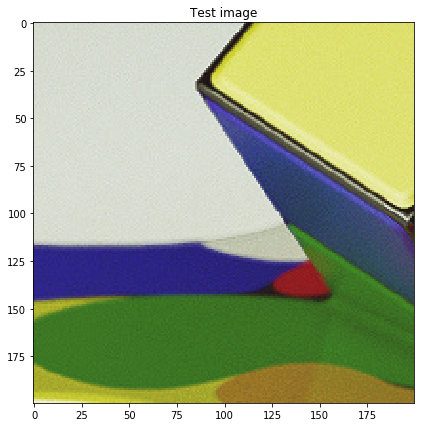

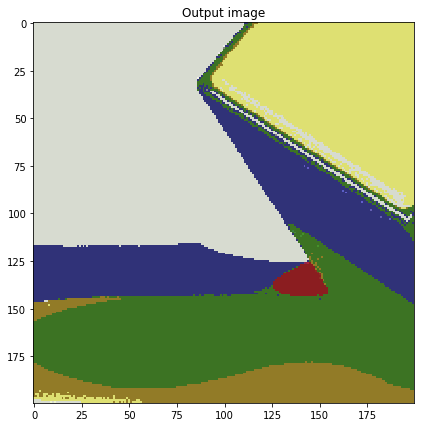

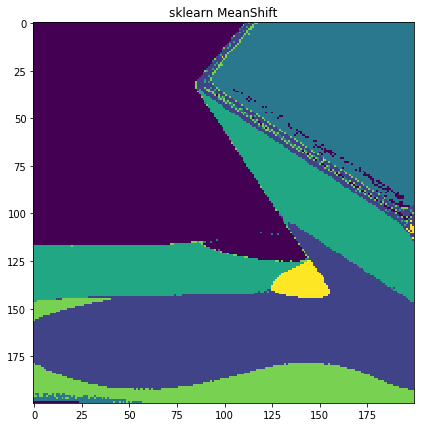

In [16]:
# from skimage.filters import gaussian
# im_test = (gaussian(im, sigma=1, multichannel=True)*255).astype('u1')
im_test = im.copy()
plt.figure(figsize=(7,7))
plt.title('Test image')
plt.imshow(im_test)

# Use a common kernel radius for comparison
from sklearn.cluster import estimate_bandwidth
bandwidth = estimate_bandwidth(im_test.reshape((-1, 3)), quantile=.2, n_samples=500)
print('bandwidth',bandwidth)

# Our mean-shift implementation
im_out = im_mean_shift(im_test, bandwidth)
plt.figure(figsize=(7,7))
plt.title('Output image')
plt.imshow(im_out)
unique_colors = np.vstack({tuple(row) for row in im_out.reshape((-1,3))})
print('im_mean_shift #clusters', unique_colors.shape[0])

# sklearn mean-shift implementation
from sklearn.cluster import MeanShift
ms = MeanShift(bandwidth, bin_seeding=True)
ms.fit(im_test.reshape((-1, 3)))
plt.figure(figsize=(7,7))
plt.title('sklearn MeanShift')
plt.imshow(np.reshape(ms.labels_, im_test.shape[:2]))
print('sklearn MeanShift #clusters', len(np.unique(ms.labels_)))

## That's some progress!
 -- though just a tolerable naive implementation.

So memorization reduced time complexity from O(image size **squared** \* max_iterations) to O(quantized feature space size \* image size \* max_iterations) at cost of extra space complexity of O(quantized feature space size). But asymptotically the extra space complexity is like nothing because (quantized feature space size)<(feature space size)=O(image size).


## Optimization 2

Consider this, if we started off by running mean-shift on the quantized feature space, then associated the mean-shift result back to image pixels. The memorization can be removed.

The logic goes like this:

(Mean-shift image) = ((memorized Mean-shift) image) = (find image (Mean-shift (unique image)))
where (unique image) converts image into feature space and lose spatial information and (find needle haystack) restores spatial information.

Let N = (image size), Q = (quantized feature space size), M = max_iterations

### Comparison
**(Mean-shift image)**
+ Time complexity = O(N^2 M)
+ Space complixity = O(N)

**((memorized Mean-shift) image)**
+ Time complexity = O(N Q M)
+ Space complixity = O(N) + O(Q) = O(N)

**(find image (Mean-shift (unique image)))**
+ Time complexity = O(N log Q) + O(Q ^2) + O(Q log Q) = O(N log Q) + O(Q ^2 M)
+ Space complixity = O(N)

## Result looks decent so far... Why so many clusters more than sklearn?

The test image can be segmented within tolerable amount of time. And result looks good (noise and reflection gone).

In [17]:
unique_colors # clusters from im_mean_shift()

array([[ 91,  96, 198],
       [142,  45,  36],
       [233, 238, 232],
       [240, 240, 154],
       [146, 123,  39],
       [237, 243, 207],
       [147,  35,  73],
       [143,  41,  29],
       [226, 234, 237],
       [215, 219, 208],
       [130, 132, 131],
       [ 70, 136,  62],
       [100,  95, 179],
       [132,  51,  34],
       [ 48,  50, 120],
       [176,  37,  56],
       [ 99,  95, 205],
       [ 99, 102, 197],
       [139,  29,  32],
       [ 70, 145,  44],
       [234, 228, 232],
       [136,  42,  94],
       [100,  91, 198],
       [ 59, 129,  67],
       [241, 241, 231],
       [ 60, 115,  35],
       [222, 224, 114],
       [ 66, 139,  50]], dtype=uint8)

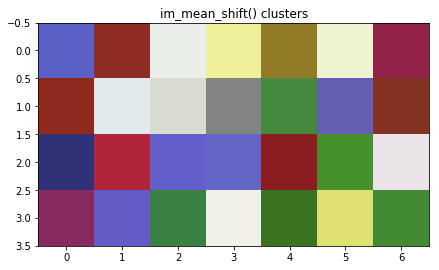

In [18]:
plt.figure(figsize=(7,7))
plt.title('im_mean_shift() clusters')
plt.imshow(unique_colors.reshape(4,-1,3))

## To be continued...

Related links:

1. [Scalable mean-shift clustering in a few lines of python](http://sociograph.blogspot.com/2011/11/scalable-mean-shift-clustering-in-few.html)
2. [mean_shift.py](https://gist.github.com/conradlee/1376528#file-mean_shift-py)
3. [sklearn MeanShift](https://github.com/scikit-learn/scikit-learn/blob/14031f6/sklearn/cluster/mean_shift_.py#L282)